# Introduction

In this project, we will build a **note-taking mobile application**. In this application, the user will be able to:

1. Create, edit, and rename different note pages
2. Type notes, as all regular note-taking applications allow
3. Write the notes using the phone's touchscreen

A screenshot of the design of the app can be seen below:

<img src="./images/app_screenshot.jfif" width="200" />

The **main objective** of this notebook **is to document** the development of the third feature, writing the notes using the phone's touchscreen. For this feature, the application will have to use a **Machine Learning model to analyze and identify the hand-written words/digits** that the user wrote, in order to then convert them to text.
![Image](https://miro.medium.com/max/1400/1*4TJWlK-FPhskEIJshfEx5g.jpeg)

As such, the flow of the project is as follows:

1. **[Data Preparation](#data_preparation)**: In this section, we describe, and clean the datasets used for model training

2. **[Preprocessing](#preprocessing)**: In this section, we define the preprocessing that needs to be done on input data before feeding it to the model

3. **[Modelling](#modelling)**: In this section, we build different models and evaluate each in order to come up with a final choice on which model to adopt in our application

4. **[Deployment](#deployment)**: In this section, we discuss how the model was deployed and interfaced with the built mobile application

5. **[Conclusion](#conclusion)**: In this section, we conclude the project

# Data Preparation

# Preprocessing <a id='preprocessing'></a>

As an initial step, we need to find a way to extract the character from the image. 

To do so, we can use OpenCV's contour function. 
<p style="color: red">INSERT EXPLANATION OF HOW THE CONTOURS WORK</p> 

We decide to crop the image with size **because********************

Having said that, we can now write a function that gets the bounding box around a certain character in an image.

In [38]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import itertools

In [39]:
def get_bounding_box(input_dir, fname, output_directory="", write=False):
    """
    Extracts the letter from an image by getting bounding boxes and resizes 
    the photo to 40x30x3 (RGB color stays)

    Parameters
    ----------
    input_dir : string
        Directory that contains the file to be analyzed (excluding the name of the file).
    fname : string
        The name of the file to be analyzed.
    output_directory : string
        Directory where the resulting file should be saved.
    show : boolean, optional
        Displays the image using OpenCV if True. The default is False.

    Returns
    -------
    ndarray
        Original image with bounding boxes applied on it.
    letter_imgs : list
        List of cropped images from the bounding boxes.
        
    """

    image = cv2.imread(f"{input_dir}/{fname}")
    original = image.copy()

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255,
                           cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    bounding_rects = [cv2.boundingRect(c) for c in cnts]

    letter_imgs = []

    for index, (x, y, w, h) in enumerate(bounding_rects):
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)

        t, imbw = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
        ROI = original[y:y + h, x:x + w]
        imbw = imbw[y:y + h, x:x + w]
        ROI = cv2.resize(ROI, (40, 30), interpolation=cv2.INTER_CUBIC)[:, :, 0]
        imbw = cv2.resize(imbw, (40, 30), interpolation=cv2.INTER_CUBIC)

        letter_imgs.append(imbw)

        if write:
            ext_pos = fname.rfind(".")
            file_name = fname[:ext_pos] + f"_{index}" + fname[ext_pos:]
            cv2.imwrite(f'{output_directory}/{file_name}', imbw)

    return (image[:, :, ::-1], letter_imgs)

Let's test it out:

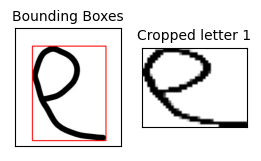

In [40]:
image_with_boxes, cropped = get_bounding_box("../src/test_images",
                                             "test_0.jpg",
                                             "../src/test_images/results")
plt.figure(figsize=(3, 3))

plt.subplot(1, len(cropped) + 1, 1)
plt.imshow(image_with_boxes)
plt.title("Bounding Boxes", fontsize=10)
plt.xticks([])
plt.yticks([])

for i, letter in enumerate(cropped):
    plt.subplot(1, len(cropped) + 1, i + 2)
    plt.imshow(letter, cmap="gray")
    plt.title(f"Cropped letter {i+1}", fontsize=10)
    plt.xticks([])
    plt.yticks([])

The above algorithm can also detect multiple letters in the same image:

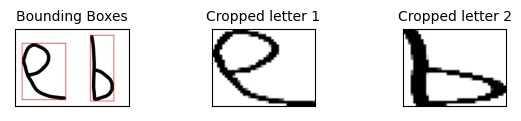

In [41]:
image_with_boxes, cropped = get_bounding_box("../src/test_images",
                                             "test_01.jpg")

plt.figure(figsize=(7, 1))

plt.subplot(1, len(cropped) + 1, 1)
plt.imshow(image_with_boxes)
plt.title("Bounding Boxes", fontsize=10)
plt.xticks([])
plt.yticks([])

for i, letter in enumerate(cropped):
    plt.subplot(1, len(cropped) + 1, i + 2)
    plt.imshow(letter, cmap="gray")
    plt.title(f"Cropped letter {i+1}", fontsize=10)
    plt.xticks([])
    plt.yticks([])

However, as used now, the algorithm might generate undesired results. For instance, when writing the letter A, the user might draw it in such a way that the dash connecting the two sides might not intersect them. In this case, the algorithm would detect two objects, instead of one connected A. This case is also seen with letters that take in a *dot*, such as the 'i' or the 'j'. Below is an example:

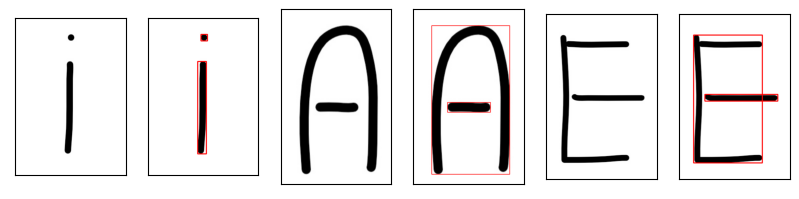

In [42]:
i, _ = get_bounding_box("./images", fname="letter_i.jpg")
A, _ = get_bounding_box("./images", fname="letter_A.jpg")
E, _ = get_bounding_box("./images", fname="letter_E.jpg")
i1 = matplotlib.image.imread("./images/letter_i.jpg")
A1 = matplotlib.image.imread("./images/letter_A.jpg")
E1 = matplotlib.image.imread("./images/letter_E.jpg")
to_show = [(i1, i), (A1, A), (E1, E)]

plt.figure(figsize=(10, 5))
i = 1
for letter, bounded_letter in to_show:
    plt.subplot(1, 6, i)
    plt.imshow(letter)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 6, i + 1)
    plt.imshow(bounded_letter)
    plt.xticks([])
    plt.yticks([])
    i += 2

Therefore, we must alter the traditional functionality to take into account such instances.

In order to do so, we will define a function called *merge_near* that cycles through the boxes and merges those that fall under certain conditions. Mainly, we have 3 relative position:

1. One box is fully contained within the other. this is like the example of the letter 'A'
2. The two boxes overlap, with either one starting within the other and ending out of it, or vice versa.
3. Both boxes are separate with no overlap                                                

To be able to distinguish the cases, we will use a certain *threshold* that defines a radius of proximity for both the horizontal dimension and the vertical dimension. In our case, we want to merge the boxes if:
1. They're fully contained within each other
2. They're partially contained within each other, such that the distance between the extremiites of one and the other falls within the aforementioned threshold.

In [43]:
def merge_near(boxes, hor_threshold=10, ver_threshold=10, merge_dots = False):
    """
    Takes a list of bounding boxes and merges those that are either fully 
    contained within other, within a certain radius of each other, 
    
    Parameters
    ----------
    boxes : list
        Original list of bounding boxes.

    hor_threshold : int, optional
        The horziontal threshold with which to consider two boxes near each 
        other. Basically, defines the horizontal radius. The default is 10.
    ver_threshold : int, optional
        The vertical threshold with which to consider two boxes near each 
        other. Basically, defined the vertical radius. The default is 10.
    merge_dots : bool, optional
        Flag to signal if we're merging dots usual shapes. This is done
        because dots need a different vertical threshold than the normal 
        shapes. The default is False.

    Returns
    -------
    list
        Updated list with merged boxes.

    """

    #Final list that is returned
    prev = boxes.copy()      
    
    changed = True
    merged_boxes = set({})
    
    #As long as changes are being made, keep on looping through the list
    while changed == True:              
        
        changed = False
        updated = []

        #If we are checking dots, filter the list for dots only
        if merge_dots:
            dots = [(x,y,w,h) for x,y,w,h in prev if w<140 and h<140]
            combinations = list(itertools.product(prev, dots))
        else:
            combinations = list(itertools.product(prev, prev))
            
        combinations = [e for e in combinations if e[0] != e[1]]
        
        #Loop through the boxes in the list -that includes the merged boxes-
        for pos, ((x1, y1, w1, h1), (x2, y2, w2, h2)) in enumerate(combinations):   
            
            #If a change was made, break out of the loop to do another iteration
            if changed == False:
                #Calculate different relative positions
                #You have 3 cases:  Fully contained within each other
                #                   Starts inside, ends outside / starts outside, ends inside
                #                   Starts outside, ends outside                                                
                #Note that we don't have the starting outside and ending inside because it is the same but different perspective, which we account for                                      
                
                #We want to merge if:   Fully contained 
                #                       Starts within ends outside, provided other dimension's difference is within threshold
                #                       Starts outside ends outside, provided both dimensions' differences are within threshold
                #Note that, while the difference might catch the starts inside, it is bounded by the threshold. So if the second rect starts within but is much larger, the difference in extremities will be > threshold. However, we still want to merge
                
                is_start_contained_hor = (x2 < x1 + w1 and x2 > x1)
                is_start_contained_ver = (y2 < y1 + h1 and y2 > y1)
                is_end_contained_hor = (x2 + w2 < x1 + w1 and x2 + w2 > x1)
                is_end_contained_ver = (y2 + h2 < y1 + h1 and y2 + h2> y1)
                is_contained = is_start_contained_hor and is_start_contained_ver and is_end_contained_hor and is_end_contained_ver
                are_extremities_threshold_hor = np.abs(x2 + w2 - x1) < hor_threshold or np.abs(x1 + w1 - x2) < hor_threshold
                are_extremities_threshold_ver = np.abs(y2 + h2 - y1) < ver_threshold or np.abs(y1 + h1 - y2) < ver_threshold
                
                if (is_contained or (
                        is_start_contained_hor and are_extremities_threshold_ver) or (
                            is_start_contained_ver and are_extremities_threshold_hor) or (
                                are_extremities_threshold_ver and are_extremities_threshold_hor)):
                    
                
                    
                    
                    #Note down the updated coordinates of the merged boxes
                    updated_x = min(x1,x2)
                    updated_y = min(y1,y2)
                    #Update the widths and height by getting final point - start point
                    updated_w = max(x1+w1, x2+w2) - updated_x
                    updated_h = max(y1+h1, y2+h2) - updated_y
                    
                    updated.append((updated_x, updated_y, updated_w, updated_h))
                    
                    merged_boxes.add((x1,y1,w1,h1))
                    merged_boxes.add((x2,y2,w2,h2))
                    
                    changed = True
                    
                    #Add all other boxes to updated for rerun
                    for box in boxes:
                        if box not in merged_boxes:
                            updated.append(box)
                    prev = updated
        
            else:
                break

    return prev if prev else boxes 

We also define an updated version of *get_bounding_boxes* that takes the merging into consideration:

In [44]:
def get_bounding_box(input_dir, fname, output_directory="", merge=True):
    """
    Extracts the letter from an image by getting bounding boxes and resizes 
    the photo to 40x30x3 (RGB color stays)

    Parameters
    ----------
    input_dir : string
        Directory that contains the file to be analyzed (excluding the name of the file).
    fname : string
        The name of the file to be analyzed.
    output_directory : string, optional
        Directory where the resulting file should be saved. If not present,
        no file is saved. The default is "".
    merge : bool, optional
        Flag to decide whether to run the merge algorithm or not. The default 
        is True.

    Returns
    -------
    ndarray
        Original image with bounding boxes applied on it.
    letter_imgs : list
        List of cropped images from the bounding boxes.

    """
        
        
    image = cv2.imread(f"{input_dir}/{fname}")
    original = image.copy()
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1] 
    
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    
    bounding_rects = [cv2.boundingRect(c) for c in cnts]
    
    
    #Run the merge algorithm twice: once to catch the dots, and once for the others
    if merge:
        bounding_rects = merge_near(bounding_rects, hor_threshold=5, ver_threshold=100, merge_dots=True)    
        bounding_rects = merge_near(bounding_rects, hor_threshold=5, ver_threshold=10)
    
    
    letter_imgs = []
    
    for index, (x,y,w,h) in enumerate(bounding_rects):    
        cv2.rectangle(image, (x, y), (x + w, y + h), (0,0,255), 2)
        
        
        t, imbw = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
        ROI = original[y:y+h, x:x+w]
        imbw = imbw[y:y+h, x:x+w]
        ROI = cv2.resize(ROI, (28, 28), interpolation = cv2.INTER_CUBIC)[:,:,0]
        imbw = cv2.resize(imbw, (28, 28), interpolation = cv2.INTER_CUBIC)
        
        letter_imgs.append(imbw)

        if output_directory:
            ext_pos = fname.rfind(".")
            file_name = fname[:ext_pos] + f"_{index}" + fname[ext_pos:]
            cv2.imwrite(f'{output_directory}/{file_name}', imbw)
            
    
    return (image[:,:,::-1], letter_imgs)

We can test the function on different inputs to see how it differs from the original one.

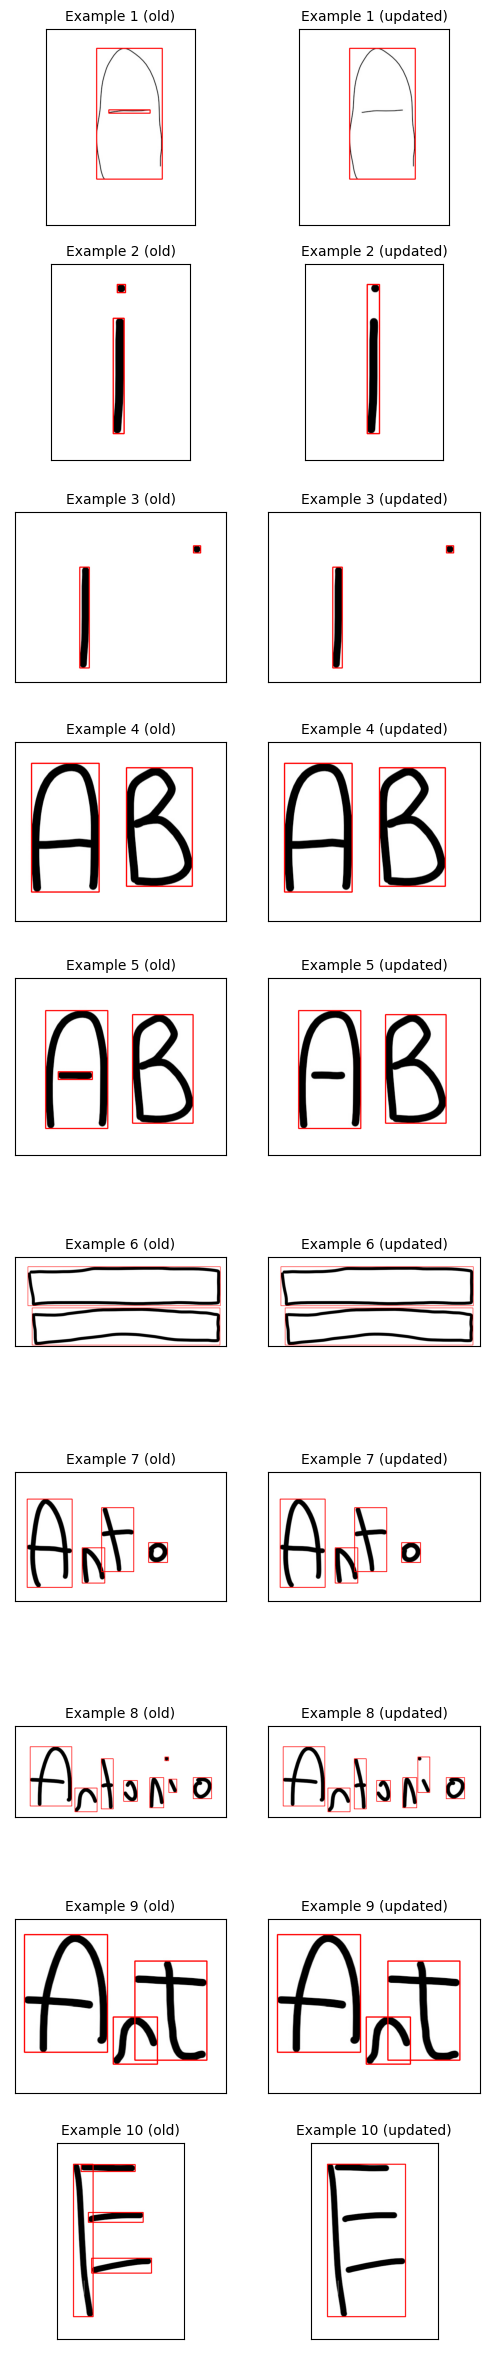

In [45]:
plt.figure(figsize=(6, 30))

s = 1
for i in range(1, 11):
    fname = f"test_{i}.jpg"

    plt.subplot(10, 2, s)
    old, _ = get_bounding_box("../src/test_images", fname, merge=False)
    plt.imshow(old)
    plt.title(f"Example {i} (old)", fontsize=10)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(10, 2, s + 1)
    im, _ = get_bounding_box("../src/test_images", fname, merge=True)
    plt.imshow(im)
    plt.title(f"Example {i} (updated)", fontsize=10)
    plt.xticks([])
    plt.yticks([])

    s += 2

We can see that the bounding boxes are created as required, with dots, neighboring boxes, and contained boxes being merged with their respective parents/neighbors.

# Modelling <a id='modelling'></a>

After having processed the input into an array that represents a cropped version of the letter, we need to build a model that will recognize the handwritten digit/character.

We will build several models, and for each, we will report the model's accuracy, precision, recall, and F-Value, as well as providing the model's confusion matrix.

We will be building four main models before combining some of them in an ensemble to create an even better model:

1. [Random Forest](#random_forest)
2. [Neural Network (Built from Scratch)](#nn_scratch)
3. [Neural Network (using Tensorflow)](#nn_tensorflow)
4. [Convolutional Neural Network (using Tensorflow)](#cnn)

## Random Forest <a id='random_forest'></a>

### Brief Explanation

<p style="color:red">Brief explanation of random forest and parametric learners</p>

The analysis of different parameteric models was conducted in a separate notebook. Out of all these models, the Random Forest achieved the best accuracy. For details, refer to [this notebook](https://github.com/t0t0-01/Handwritten-Digit-Letter-Recognition-App/blob/main/Testing_Models.ipynb).

For ease of reference, the results and accuracies of the model are listed below:

<p style="color: red">Include Random Forest results</p>

## Neural Network (from Scratch) <a id='nn_scratch'></a>

As a first step, we took the initiative to write our functions for the computation of the neural network. We built, in total, 5 modules that follow a similar syntax to the Tensorflow API:

**1. Fully Connected Layer:** This is equivalent to the Dense layer in the Tensorflow/Pytorch API. It consists of neurons that are fully connected to each other.
<img width="200" src="https://www.oreilly.com/api/v2/epubs/9781491980446/files/assets/tfdl_0401.png" />

**2. ReLu Activation Layer:** This is the Rectified Linear Unit non-linearity (activation layer) used at the end of the fully connected layers. It has the following graph:
<img width="400" src="https://iq.opengenus.org/content/images/2021/12/relu.png" />


**3. Softmax Activation Layer:** This is the Softmax layer used at the output of the model. It is used to convert the predictions of the final dense layer into probabilities. It has the following formula:
<img width="200" src="https://lh6.googleusercontent.com/3vcfJ5hJhsMZAMFIbQOEycfVW1t6rh1CXt62DeMk8RPPXVzV4vCcURNm_z_F7618uAeSHT7qT7wE_UiK5Ic0b-Eeuunn6iTGeHWbpAaUAP6-G2ePubeGWCb4_TmSapeaimZqvuUs" />


**4. Cross Entropy Loss:** This is equivalent to the categorical cross entropy loss used in tensorflow. It calculates the loss based on the predicted vs. the expected labels. Below is the formula for the binary cross entropy loss, which is the basis for the categorical cross entropy we need for the purposes of this project.

<img width="400" src="https://github.com/t0t0-01/Handwritten-Digit-Letter-Recognition-App/blob/main/images/binary_cross_entropy.jpg?raw=true" />


**5. Sequential Model:** This is the Sequential Model that cascades/stacks different layers togethers.

The detailed implementation of these layers can be found in the *layers* directory under the *src* folder. For the purposes of this notebook, we will simply be loading the model and testing it.

In [4]:
#Import the files from the folders
from layers.full import FullLayer as FullLayer_InHouse
from layers.softmax import SoftMaxLayer as SoftMaxLayer_InHouse
from layers.cross_entropy import CrossEntropyLayer as CrossEntropyLayer_InHouse
from layers.sequential import Sequential as Sequential_InHouse
from layers.relu import ReluLayer as ReluLayer_InHouse

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

In [30]:
lr = 10
INPUT_LENGTH = 784

x_train = []
y_train = []
train_dataset_unbatched = train_dataset.unbatch()
#It is a list of tuples, where in each tuple you have a batch of input, then a batch of labels
for image, label in train_dataset_unbatched:
    x_train.append(image)
    y_train.append(label)
x_train = np.array(x_train)
y_train = np.array(y_train)

#Flatten the image into a vector
x_train = [element.flatten() for element in x_train]
x_train = np.array(x_train)
print(x_train.shape)
print(y_train.shape)
print(y_train[0])

(6464, 784)
(6464, 62)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


[[ 0.02321906  0.08524425  0.01028892 ...  0.05632837 -0.02132883
   0.0758577 ]
 [ 0.01015518  0.01030595  0.04064391 ... -0.03605641  0.04665164
  -0.06771157]
 [ 0.08245981  0.06760736 -0.01559578 ... -0.00042653 -0.06677744
   0.02374186]
 ...
 [ 0.04802726  0.01703399  0.06715216 ...  0.01901784  0.02489538
  -0.06003412]
 [-0.02276281  0.07008459  0.0609258  ...  0.01095232  0.04217019
  -0.04378204]
 [-0.05510041  0.02337553  0.00728264 ... -0.03125017 -0.00422158
   0.03867158]]
[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668

[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668e+01 -9.86746234e+00]
 [-6.80200483e+00 -6.40019612e+00 -7.62513360e+00 ... -5.50438181e+00
  -8.78754870e+00 -9.49818186e+00]]
[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.2242335

[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668e+01 -9.86746234e+00]
 [-6.80200483e+00 -6.40019612e+00 -7.62513360e+00 ... -5.50438181e+00
  -8.78754870e+00 -9.49818186e+00]]
[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.2242335

[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668e+01 -9.86746234e+00]
 [-6.80200483e+00 -6.40019612e+00 -7.62513360e+00 ... -5.50438181e+00
  -8.78754870e+00 -9.49818186e+00]]
[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.2242335

[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668e+01 -9.86746234e+00]
 [-6.80200483e+00 -6.40019612e+00 -7.62513360e+00 ... -5.50438181e+00
  -8.78754870e+00 -9.49818186e+00]]
[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.2242335

[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668e+01 -9.86746234e+00]
 [-6.80200483e+00 -6.40019612e+00 -7.62513360e+00 ... -5.50438181e+00
  -8.78754870e+00 -9.49818186e+00]]
[[-1.18689470e-01 -1.70497166e-01  3.04316419e+01 ... -1.29016865e-01
  -9.16949427e-01  1.06533635e+01]
 [ 1.83207080e+01 -1.25201172e-01  2.58849759e+01 ...  5.45767965e+00
   4.71207174e+01  5.69354637e+00]
 [ 3.33971017e-02  3.47447635e-02  2.04709118e+01 ...  1.26491995e-01
   9.37102651e+00  9.09597839e+00]
 ...
 [-6.59407387e-02 -4.18288363e-02  2.5650423

[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668e+01 -9.86746234e+00]
 [-6.80200483e+00 -6.40019612e+00 -7.62513360e+00 ... -5.50438181e+00
  -8.78754870e+00 -9.49818186e+00]]
[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.2242335

[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668e+01 -9.86746234e+00]
 [-6.80200483e+00 -6.40019612e+00 -7.62513360e+00 ... -5.50438181e+00
  -8.78754870e+00 -9.49818186e+00]]
[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.2242335

[[-1.18689470e-01 -1.70497166e-01  3.04316419e+01 ... -1.29016865e-01
  -9.16949427e-01  1.06533635e+01]
 [ 1.83207080e+01 -1.25201172e-01  2.58849759e+01 ...  5.45767965e+00
   4.71207174e+01  5.69354637e+00]
 [ 3.33971017e-02  3.47447635e-02  2.04709118e+01 ...  1.26491995e-01
   9.37102651e+00  9.09597839e+00]
 ...
 [-6.59407387e-02 -4.18288363e-02  2.56504236e+00 ...  1.18603467e+01
   3.12956024e+01  2.45333480e-02]
 [ 1.48324641e+01 -1.91453514e-02  8.77580936e+00 ...  1.95440350e+01
   3.06750334e+01  3.36854584e+01]
 [ 7.23408124e+00 -1.55776018e-01  1.13897339e+01 ... -1.48402858e-01
   9.01949205e+00  8.84656102e+00]]
[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.2242335

[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668e+01 -9.86746234e+00]
 [-6.80200483e+00 -6.40019612e+00 -7.62513360e+00 ... -5.50438181e+00
  -8.78754870e+00 -9.49818186e+00]]
[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.2242335

[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668e+01 -9.86746234e+00]
 [-6.80200483e+00 -6.40019612e+00 -7.62513360e+00 ... -5.50438181e+00
  -8.78754870e+00 -9.49818186e+00]]
[[-1.18689470e-01 -1.70497166e-01  3.04316419e+01 ... -1.29016865e-01
  -9.16949427e-01  1.06533635e+01]
 [ 1.83207080e+01 -1.25201172e-01  2.58849759e+01 ...  5.45767965e+00
   4.71207174e+01  5.69354637e+00]
 [ 3.33971017e-02  3.47447635e-02  2.04709118e+01 ...  1.26491995e-01
   9.37102651e+00  9.09597839e+00]
 ...
 [-6.59407387e-02 -4.18288363e-02  2.5650423

[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668e+01 -9.86746234e+00]
 [-6.80200483e+00 -6.40019612e+00 -7.62513360e+00 ... -5.50438181e+00
  -8.78754870e+00 -9.49818186e+00]]
[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.2242335

[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668e+01 -9.86746234e+00]
 [-6.80200483e+00 -6.40019612e+00 -7.62513360e+00 ... -5.50438181e+00
  -8.78754870e+00 -9.49818186e+00]]
[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.2242335

[[-1.18689470e-01 -1.70497166e-01  3.04316419e+01 ... -1.29016865e-01
  -9.16949427e-01  1.06533635e+01]
 [ 1.83207080e+01 -1.25201172e-01  2.58849759e+01 ...  5.45767965e+00
   4.71207174e+01  5.69354637e+00]
 [ 3.33971017e-02  3.47447635e-02  2.04709118e+01 ...  1.26491995e-01
   9.37102651e+00  9.09597839e+00]
 ...
 [-6.59407387e-02 -4.18288363e-02  2.56504236e+00 ...  1.18603467e+01
   3.12956024e+01  2.45333480e-02]
 [ 1.48324641e+01 -1.91453514e-02  8.77580936e+00 ...  1.95440350e+01
   3.06750334e+01  3.36854584e+01]
 [ 7.23408124e+00 -1.55776018e-01  1.13897339e+01 ... -1.48402858e-01
   9.01949205e+00  8.84656102e+00]]
[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.2242335

[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668e+01 -9.86746234e+00]
 [-6.80200483e+00 -6.40019612e+00 -7.62513360e+00 ... -5.50438181e+00
  -8.78754870e+00 -9.49818186e+00]]
[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.2242335

[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668e+01 -9.86746234e+00]
 [-6.80200483e+00 -6.40019612e+00 -7.62513360e+00 ... -5.50438181e+00
  -8.78754870e+00 -9.49818186e+00]]
[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.2242335

[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668e+01 -9.86746234e+00]
 [-6.80200483e+00 -6.40019612e+00 -7.62513360e+00 ... -5.50438181e+00
  -8.78754870e+00 -9.49818186e+00]]
[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.2242335

[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668e+01 -9.86746234e+00]
 [-6.80200483e+00 -6.40019612e+00 -7.62513360e+00 ... -5.50438181e+00
  -8.78754870e+00 -9.49818186e+00]]
[[-1.18689470e-01 -1.70497166e-01  3.04316419e+01 ... -1.29016865e-01
  -9.16949427e-01  1.06533635e+01]
 [ 1.83207080e+01 -1.25201172e-01  2.58849759e+01 ...  5.45767965e+00
   4.71207174e+01  5.69354637e+00]
 [ 3.33971017e-02  3.47447635e-02  2.04709118e+01 ...  1.26491995e-01
   9.37102651e+00  9.09597839e+00]
 ...
 [-6.59407387e-02 -4.18288363e-02  2.5650423

[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668e+01 -9.86746234e+00]
 [-6.80200483e+00 -6.40019612e+00 -7.62513360e+00 ... -5.50438181e+00
  -8.78754870e+00 -9.49818186e+00]]
[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.2242335

[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668e+01 -9.86746234e+00]
 [-6.80200483e+00 -6.40019612e+00 -7.62513360e+00 ... -5.50438181e+00
  -8.78754870e+00 -9.49818186e+00]]
[[-1.18689470e-01 -1.70497166e-01  3.04316419e+01 ... -1.29016865e-01
  -9.16949427e-01  1.06533635e+01]
 [ 1.83207080e+01 -1.25201172e-01  2.58849759e+01 ...  5.45767965e+00
   4.71207174e+01  5.69354637e+00]
 [ 3.33971017e-02  3.47447635e-02  2.04709118e+01 ...  1.26491995e-01
   9.37102651e+00  9.09597839e+00]
 ...
 [-6.59407387e-02 -4.18288363e-02  2.5650423

[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668e+01 -9.86746234e+00]
 [-6.80200483e+00 -6.40019612e+00 -7.62513360e+00 ... -5.50438181e+00
  -8.78754870e+00 -9.49818186e+00]]
[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.2242335

[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668e+01 -9.86746234e+00]
 [-6.80200483e+00 -6.40019612e+00 -7.62513360e+00 ... -5.50438181e+00
  -8.78754870e+00 -9.49818186e+00]]
[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.2242335

[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668e+01 -9.86746234e+00]
 [-6.80200483e+00 -6.40019612e+00 -7.62513360e+00 ... -5.50438181e+00
  -8.78754870e+00 -9.49818186e+00]]
[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.2242335

[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668e+01 -9.86746234e+00]
 [-6.80200483e+00 -6.40019612e+00 -7.62513360e+00 ... -5.50438181e+00
  -8.78754870e+00 -9.49818186e+00]]
[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.2242335

[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668e+01 -9.86746234e+00]
 [-6.80200483e+00 -6.40019612e+00 -7.62513360e+00 ... -5.50438181e+00
  -8.78754870e+00 -9.49818186e+00]]
[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.2242335

[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668e+01 -9.86746234e+00]
 [-6.80200483e+00 -6.40019612e+00 -7.62513360e+00 ... -5.50438181e+00
  -8.78754870e+00 -9.49818186e+00]]
[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.2242335

[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668e+01 -9.86746234e+00]
 [-6.80200483e+00 -6.40019612e+00 -7.62513360e+00 ... -5.50438181e+00
  -8.78754870e+00 -9.49818186e+00]]
[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.2242335

[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668e+01 -9.86746234e+00]
 [-6.80200483e+00 -6.40019612e+00 -7.62513360e+00 ... -5.50438181e+00
  -8.78754870e+00 -9.49818186e+00]]
[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.2242335

[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668e+01 -9.86746234e+00]
 [-6.80200483e+00 -6.40019612e+00 -7.62513360e+00 ... -5.50438181e+00
  -8.78754870e+00 -9.49818186e+00]]
[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.2242335

[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668e+01 -9.86746234e+00]
 [-6.80200483e+00 -6.40019612e+00 -7.62513360e+00 ... -5.50438181e+00
  -8.78754870e+00 -9.49818186e+00]]
[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.2242335

[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668e+01 -9.86746234e+00]
 [-6.80200483e+00 -6.40019612e+00 -7.62513360e+00 ... -5.50438181e+00
  -8.78754870e+00 -9.49818186e+00]]
[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.2242335

[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668e+01 -9.86746234e+00]
 [-6.80200483e+00 -6.40019612e+00 -7.62513360e+00 ... -5.50438181e+00
  -8.78754870e+00 -9.49818186e+00]]
[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.2242335

[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668e+01 -9.86746234e+00]
 [-6.80200483e+00 -6.40019612e+00 -7.62513360e+00 ... -5.50438181e+00
  -8.78754870e+00 -9.49818186e+00]]
[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.2242335

[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668e+01 -9.86746234e+00]
 [-6.80200483e+00 -6.40019612e+00 -7.62513360e+00 ... -5.50438181e+00
  -8.78754870e+00 -9.49818186e+00]]
[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.2242335

[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668e+01 -9.86746234e+00]
 [-6.80200483e+00 -6.40019612e+00 -7.62513360e+00 ... -5.50438181e+00
  -8.78754870e+00 -9.49818186e+00]]
[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.2242335

[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668e+01 -9.86746234e+00]
 [-6.80200483e+00 -6.40019612e+00 -7.62513360e+00 ... -5.50438181e+00
  -8.78754870e+00 -9.49818186e+00]]
[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.2242335

[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668e+01 -9.86746234e+00]
 [-6.80200483e+00 -6.40019612e+00 -7.62513360e+00 ... -5.50438181e+00
  -8.78754870e+00 -9.49818186e+00]]
[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.2242335

[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668e+01 -9.86746234e+00]
 [-6.80200483e+00 -6.40019612e+00 -7.62513360e+00 ... -5.50438181e+00
  -8.78754870e+00 -9.49818186e+00]]
[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.2242335

[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668e+01 -9.86746234e+00]
 [-6.80200483e+00 -6.40019612e+00 -7.62513360e+00 ... -5.50438181e+00
  -8.78754870e+00 -9.49818186e+00]]
[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.2242335

[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668e+01 -9.86746234e+00]
 [-6.80200483e+00 -6.40019612e+00 -7.62513360e+00 ... -5.50438181e+00
  -8.78754870e+00 -9.49818186e+00]]
[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.2242335

[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.22423350e+01 ...  9.94216350e+00
   9.97276894e+00  9.89439128e+00]
 [-8.97323750e+00 -9.00403251e+00 -1.22125478e+01 ... -1.09736051e+01
  -1.00246668e+01 -9.86746234e+00]
 [-6.80200483e+00 -6.40019612e+00 -7.62513360e+00 ... -5.50438181e+00
  -8.78754870e+00 -9.49818186e+00]]
[[-9.65637940e+00 -7.37066599e+00 -5.39365410e+00 ...  8.81273994e-01
   6.81819970e-01  2.66962721e-01]
 [ 1.01551833e-02  1.03059515e-02  4.06439082e-02 ... -3.60564063e-02
   4.66516432e-02 -6.77115678e-02]
 [-1.59393635e+01 -1.48313510e+01 -1.30036382e+01 ... -1.36203226e+01
  -1.12479129e+01 -1.10764322e+01]
 ...
 [ 1.17154039e+01  1.16818384e+01  1.2242335

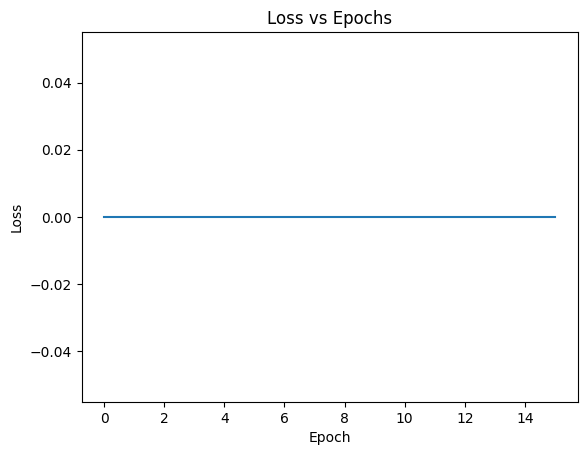

NameError: name 'x_test' is not defined

In [29]:
epochs = 15

model = Sequential_InHouse((FullLayer_InHouse(INPUT_LENGTH, 200), 
                            ReluLayer_InHouse(), 
                            FullLayer_InHouse(200, 62), 
                            SoftMaxLayer_InHouse()),
                            CrossEntropyLayer_InHouse())


losses = model.fit(x_train, y_train, epochs=epochs, lr=lr)


plt.plot(list(range(0,epochs+1)), losses, label=lr)
plt.title("Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


#predictions
y_hat = model.predict(x_test)
accuracy = np.mean(y_hat == y_test)

## Neural Network (using Tensorflow) <a id='nn_tensorflow'></a>

## Convolutional Neural Network (using Tensorflow) <a id=cnn></a>

### CNN Crash Course

A convolutional network builds on the idea of a neural network and introduces a new type of layer: the convolutional layer.

<img src="./images/cnn.webp" width=500 /> 

This layer introduces a filter, made out of cells, where each cell has a weight. The filter is *passed over* the data, multiplying, at each point, the values of the data with the weights of the kernel. Afterwards, the products are then summed to produce a single value for every cell the kernel passes over.
<img src="./images/filters.png" width=500/>

Kernels vary in size, but are usually square in shape (e.g., 2x2, 3x3). During training, the weights of the filter are updated as to produce the desired output on the training images. 

There are two main parameters that one must take into account when using convoltutional layers:

**1. Stride:** This parameter defines by how much the kernel is shifting on every iteration of the convolution

**2. Padding:** This parameter defines how the kernel will interact with cells on the boundary. In tensorflow, there are two main options:

&nbsp;&nbsp;&nbsp;&nbsp; **a. Same:** A padding of *same* appends 0 to the boundaries, in order to result in an output image of same size as the input (hence the name!)

&nbsp;&nbsp;&nbsp;&nbsp; **b. Valid:** A padding of *valid* does not add any padding to the input. In this case, some cells might be disregarded if the kernel (along with the chosen stride) does not exactly match the shape of the input.
 
Below is an image that portrays this process:
![image](./images/padding.png)

A CNN usually consists of several convolutional layers, where each layers consists of several kernels. After training, the kernels would represents a certain feature that help in predicting the output (because of this, a kernel is also referred to as *feature map*, because it *maps* the input image into a certain feature). For instance, some kernels might learn to detect edges; others might learn to detect horizontal surfaces, vertical surfaces, diagonal splits...

An example of an image of a cat being processed by a CNN is shown below:
![cat_original](./images/cat_original.png)
![cat_cnn](./images/cat_conv.png)

We can see how each kernel/feature map highlights something: for instance, some highlight the foreground, while others highlight edges.

Furthermore, the deeper the network is, the more complex the features discovered are. 

### Building a Model

Tensorflow presents a simple way to build complex CNN models. As such, we will be using it do build our CNN model.

First step is to import the data. Recall that the input images are stored inside folders, where each folder corresponds to a class. As such, we can use the *image_dataset_from_directory* function provided by TF2.

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
import pandas as pd
import tensorflow as tf
import keras

In [9]:
batch_size = 64
full_dataset = keras.utils.image_dataset_from_directory(
    "../input/updated_images",
    seed=123,
    image_size=(28, 28),
    label_mode="categorical",
    batch_size=batch_size,
    color_mode='grayscale')

number_of_batches = full_dataset.cardinality().numpy()

test_size = int(0.1 * number_of_batches)
val_size = int(0.1 * number_of_batches)
train_size = number_of_batches - test_size - val_size

train_dataset = full_dataset.take(train_size)
remaining = full_dataset.skip(train_size)
val_dataset = remaining.take(val_size)
test_dataset = remaining.skip(val_size)

print(f"Training Set contains {train_dataset.cardinality().numpy() * batch_size} entries.")
print(f"Validation Set contains {val_dataset.cardinality().numpy() * batch_size} entries.")
print(f"Testing Set contains {test_dataset.cardinality().numpy() * batch_size} entries.")

Found 7998 files belonging to 62 classes.
Training Set contains 6464 entries.
Validation Set contains 768 entries.
Testing Set contains 768 entries.


Let's visualize a couple of entries from this dataset:

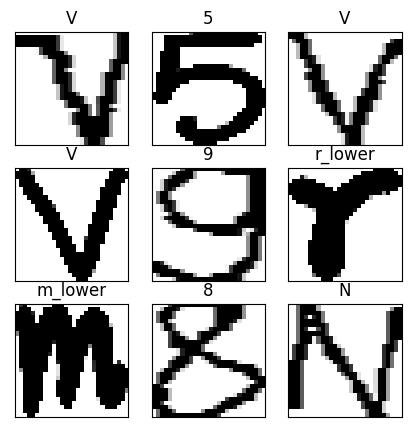

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a_lower', 'b_lower', 'c_lower', 'd_lower', 'e_lower', 'f_lower', 'g_lower', 'h_lower', 'i_lower', 'j_lower', 'k_lower', 'l_lower', 'm_lower', 'n_lower', 'o_lower', 'p_lower', 'q_lower', 'r_lower', 's_lower', 't_lower', 'u_lower', 'v_lower', 'w_lower', 'x_lower', 'y_lower', 'z_lower']


In [26]:
string_labels = full_dataset.class_names

plt.figure(figsize=(5, 5))
for batch in full_dataset.take(1):
    images, labels = batch
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i], cmap="gray")
        plt.title(string_labels[np.argmax(labels[i])])
        plt.xticks([])
        plt.yticks([])
        
plt.show()

images[i].shape
print(string_labels)

Now that the data has been imported, we can build the model and train it on this data.

In [49]:
model = Sequential()
model.add(
    Conv2D(filters=32,
           kernel_size=(3, 3),
           activation='relu',
           input_shape=(28, 28, 1),
           name="conv-1",
           padding="same"))
model.add(
    MaxPool2D(pool_size=(2, 2), strides=2, name="maxpool-1", padding="same"))
model.add(
    Conv2D(filters=64,
           kernel_size=(3, 3),
           activation='relu',
           padding='same',
           name="conv-2"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2, name="maxpool-2", padding="same"))
model.add(
    Conv2D(filters=128,
           kernel_size=(3, 3),
           activation='relu',
           padding='same',
           name="conv-3"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2, name="maxpool-3", padding="same"))
model.add(Flatten())
model.add(Dense(64, activation="relu", name="dense-1"))
model.add(Dense(128, activation="relu", name="dense-2"))
model.add(Dense(62, activation="softmax", name="dense-3"))

In short, the model has the following architecture:

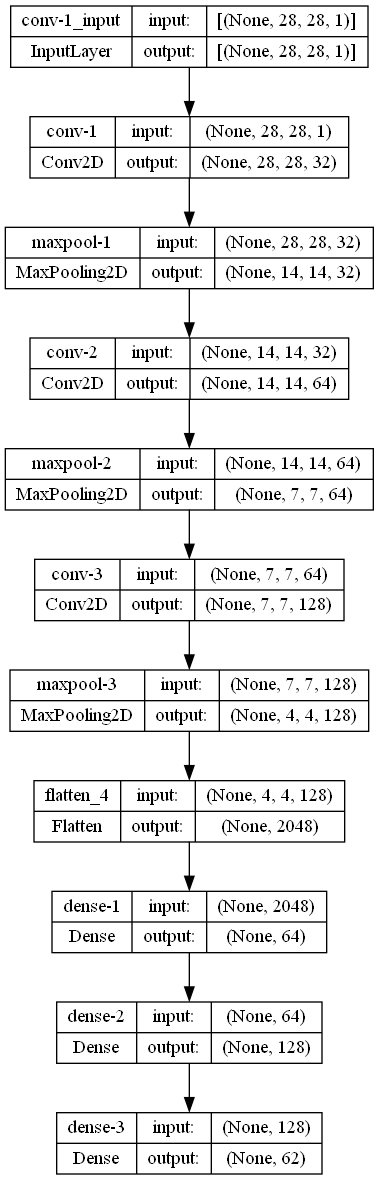

In [50]:
keras.utils.plot_model(model, show_shapes=True)

In summary:

In [51]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv-1 (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 maxpool-1 (MaxPooling2D)    (None, 14, 14, 32)        0         
                                                                 
 conv-2 (Conv2D)             (None, 14, 14, 64)        18496     
                                                                 
 maxpool-2 (MaxPooling2D)    (None, 7, 7, 64)          0         
                                                                 
 conv-3 (Conv2D)             (None, 7, 7, 128)         73856     
                                                                 
 maxpool-3 (MaxPooling2D)    (None, 4, 4, 128)         0         
                                                                 
 flatten_4 (Flatten)         (None, 2048)             

Then, we can compile the model. We will use the Adam optimizer algorithm described earlier; we will also use the categorical cross entropy loss.

In [52]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Precision(),
                  tf.keras.metrics.Recall()
              ])

In [53]:
history = model.fit(train_dataset, validation_data=val_dataset , epochs=30)

Epoch 1/30
101/101 [==============================] - 7s 59ms/step - loss: 5.8667 - accuracy: 0.0226 - precision_3: 0.0360 - recall_3: 0.0026 - val_loss: 4.0228 - val_accuracy: 0.0260 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/30
101/101 [==============================] - 6s 62ms/step - loss: 3.6865 - accuracy: 0.0623 - precision_3: 1.0000 - recall_3: 3.0941e-04 - val_loss: 3.0391 - val_accuracy: 0.1276 - val_precision_3: 0.8000 - val_recall_3: 0.0104
Epoch 3/30
101/101 [==============================] - 7s 73ms/step - loss: 2.6899 - accuracy: 0.2155 - precision_3: 0.6177 - recall_3: 0.0312 - val_loss: 2.1177 - val_accuracy: 0.3880 - val_precision_3: 0.7647 - val_recall_3: 0.1354
Epoch 4/30
101/101 [==============================] - 7s 71ms/step - loss: 1.7613 - accuracy: 0.4454 - precision_3: 0.6887 - recall_3: 0.2386 - val_loss: 1.4585 - val_accuracy: 0.5182 - val_precision_3: 0.7449 - val_recall_3: 0.3307
Epoch 5/30
101/101 [==============================] - 7s

In order to evalutate this model, we will plot the graphs of **accuracy, precision, and recall** as a function of the training epochs. We can do so using the *history* object that the *fit* function returns:

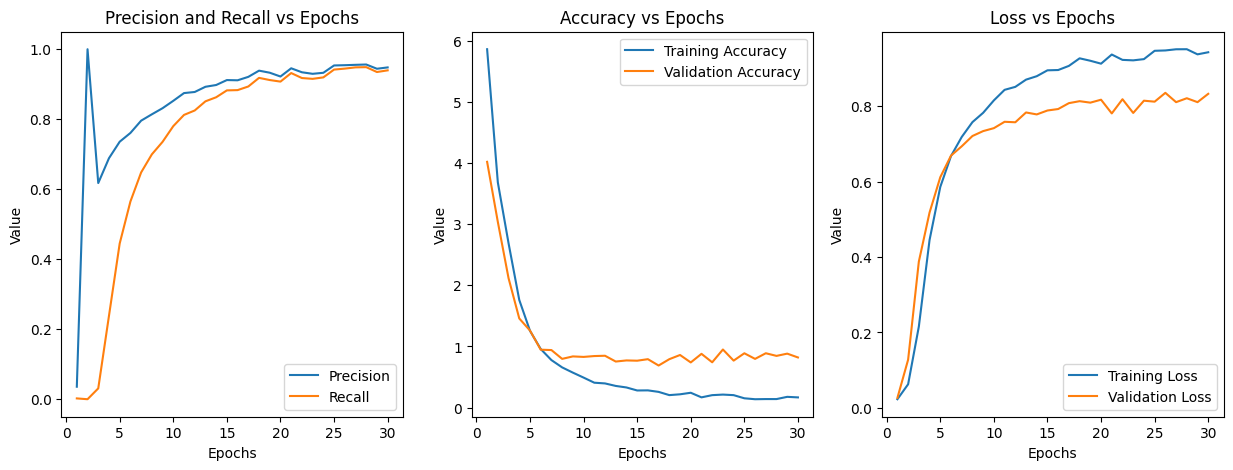

In [56]:
def plot_acc_loss_pr(train_values, val_values, pr):
    train_acc = train_values[1]
    train_loss = train_values[0]
    val_loss = val_values[0]
    val_acc = val_values[1]
    precision = pr[0]
    recall = pr[1]

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(range(1, 31), precision, label="Precision")
    plt.plot(range(1, 31), recall, label="Recall")
    plt.title("Precision and Recall vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(range(1, 31), train_acc, label="Training Accuracy")
    plt.plot(range(1, 31), val_acc, label="Validation Accuracy")
    plt.title("Accuracy vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(range(1, 31), train_loss, label="Training Loss")
    plt.plot(range(1, 31), val_loss, label="Validation Loss")
    plt.title("Loss vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.legend()


pr = history.history["precision_3"], history.history["recall_3"]
train_values = history.history["accuracy"], history.history["loss"]
val_values = history.history["val_accuracy"], history.history["val_loss"]

plot_acc_loss_pr(train_values, val_values, pr)

We will also test the model on the testing set, and report the accuracy.

In [57]:
print("Evaluate on test data")
results = model.evaluate(test_dataset)
print(f"\nTest loss: {results[0]}\nTest Accuracy: {results[1]}")

Evaluate on test data
12/12 [==============================] - 2s 13ms/step - loss: 1.2893 - accuracy: 0.7402 - precision_3: 0.7537 - recall_3: 0.7350

Test loss: 1.2893182039260864
Test Accuracy: 0.7402088642120361


We see that this model achieves an **accuracy of 74%**

### Data Augmentation

From the above graphs, we can clearly see that the model is quickly overfitting: training accuracy reaches really high levels, while validation accuracy starts eventually decreasing. Furthermore, test accuracy is not great.

Our initial hypothesis is that this is happening due to lack of extensive data. Therefore, we will proceed with augmenting the data in order to try and decrease overfitting.

For reference, data augmentation is a set of techniques to artificially increase the amount of data by generating new data points from existing data. This includes making small changes to data or using deep learning models to generate new data points.

In our case, we will be applying the following data augmentation techniques:
* **Random flip:** randomly rotates images during training. We will use a range of [-0.1, 0.1].

We will not use other transformations such as flipping, zooming, and cropping, since these might end up altering the labels of the letters.

In [58]:
data_augmentation = tf.keras.Sequential([
  keras.layers.RandomRotation(factor=(-0.05, 0.05)),
])

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Let's visualize some of these to see the rotations:

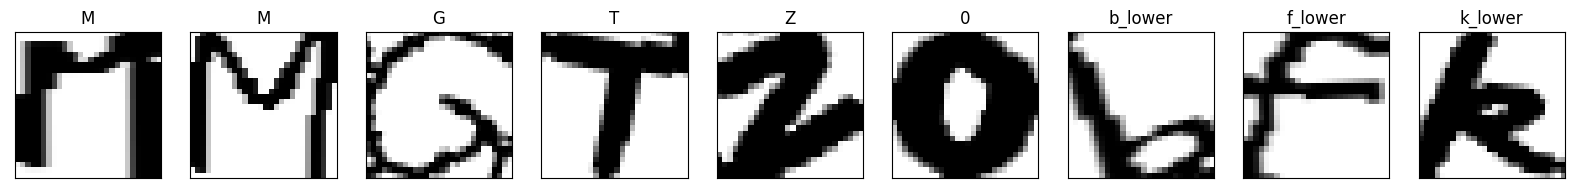

In [60]:
plt.figure(figsize=(20,30))

images, labels = list(train_dataset.take(1))[0]

for i in range(9):
    plt.subplot(1, 9, i+1)
    plt.imshow(images[i], cmap="gray")
    plt.title(string_labels[np.argmax(labels[i])])
    plt.xticks([])
    plt.yticks([])


    

Now we can rerun the training, this time using the augmented dataset.

In [62]:
model_cloned = tf.keras.models.clone_model(model)
model_cloned.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Precision(),
                  tf.keras.metrics.Recall()
              ])

EPOCHS = 30

history = model_cloned.fit(train_dataset, validation_data=val_dataset , epochs=EPOCHS)

Epoch 1/30
101/101 [==============================] - 9s 82ms/step - loss: 5.1665 - accuracy: 0.0215 - precision_5: 0.0210 - recall_5: 0.0011 - val_loss: 3.9984 - val_accuracy: 0.0430 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 2/30
101/101 [==============================] - 8s 73ms/step - loss: 3.7639 - accuracy: 0.0650 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_loss: 3.4258 - val_accuracy: 0.1354 - val_precision_5: 0.6000 - val_recall_5: 0.0039
Epoch 3/30
101/101 [==============================] - 8s 73ms/step - loss: 2.7661 - accuracy: 0.2452 - precision_5: 0.6163 - recall_5: 0.0701 - val_loss: 1.9717 - val_accuracy: 0.4310 - val_precision_5: 0.5994 - val_recall_5: 0.2630
Epoch 4/30
101/101 [==============================] - 8s 75ms/step - loss: 1.6447 - accuracy: 0.4941 - precision_5: 0.6965 - recall_5: 0.3139 - val_loss: 1.2238 - val_accuracy: 0.6016 - val_precision_5: 0.6945 - val_recall_5: 0.5091
Epoch 5/30
101/101 [==============================] 

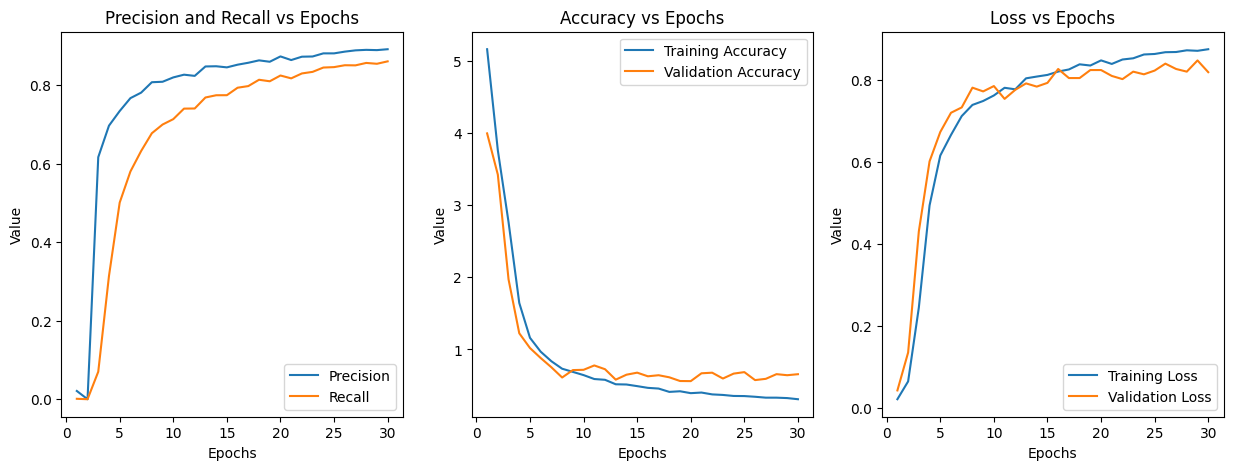

In [70]:
pr_augmented = history.history["precision_5"], history.history["recall_5"]
train_values_augmented = history.history["accuracy"], history.history["loss"]
val_values_augmented = history.history["val_accuracy"], history.history["val_loss"]

plot_acc_loss_pr(train_values_augmented, val_values_augmented, pr_augmented)

Let's evaluate on the test set:

In [71]:
print("Evaluate on test data")
results = model_cloned.evaluate(test_dataset)
print(f"\nTest loss: {results[0]}\nTest Accuracy: {results[1]}")

Evaluate on test data
12/12 [==============================] - 2s 13ms/step - loss: 0.8093 - accuracy: 0.7807 - precision_5: 0.7959 - recall_5: 0.7689

Test loss: 0.8093003034591675
Test Accuracy: 0.7806788682937622


We can see that the model has become more resistant to overfitting!

Let's also plot the confusion matrix:

12/12 [==============================] - 2s 12ms/step


<AxesSubplot: >

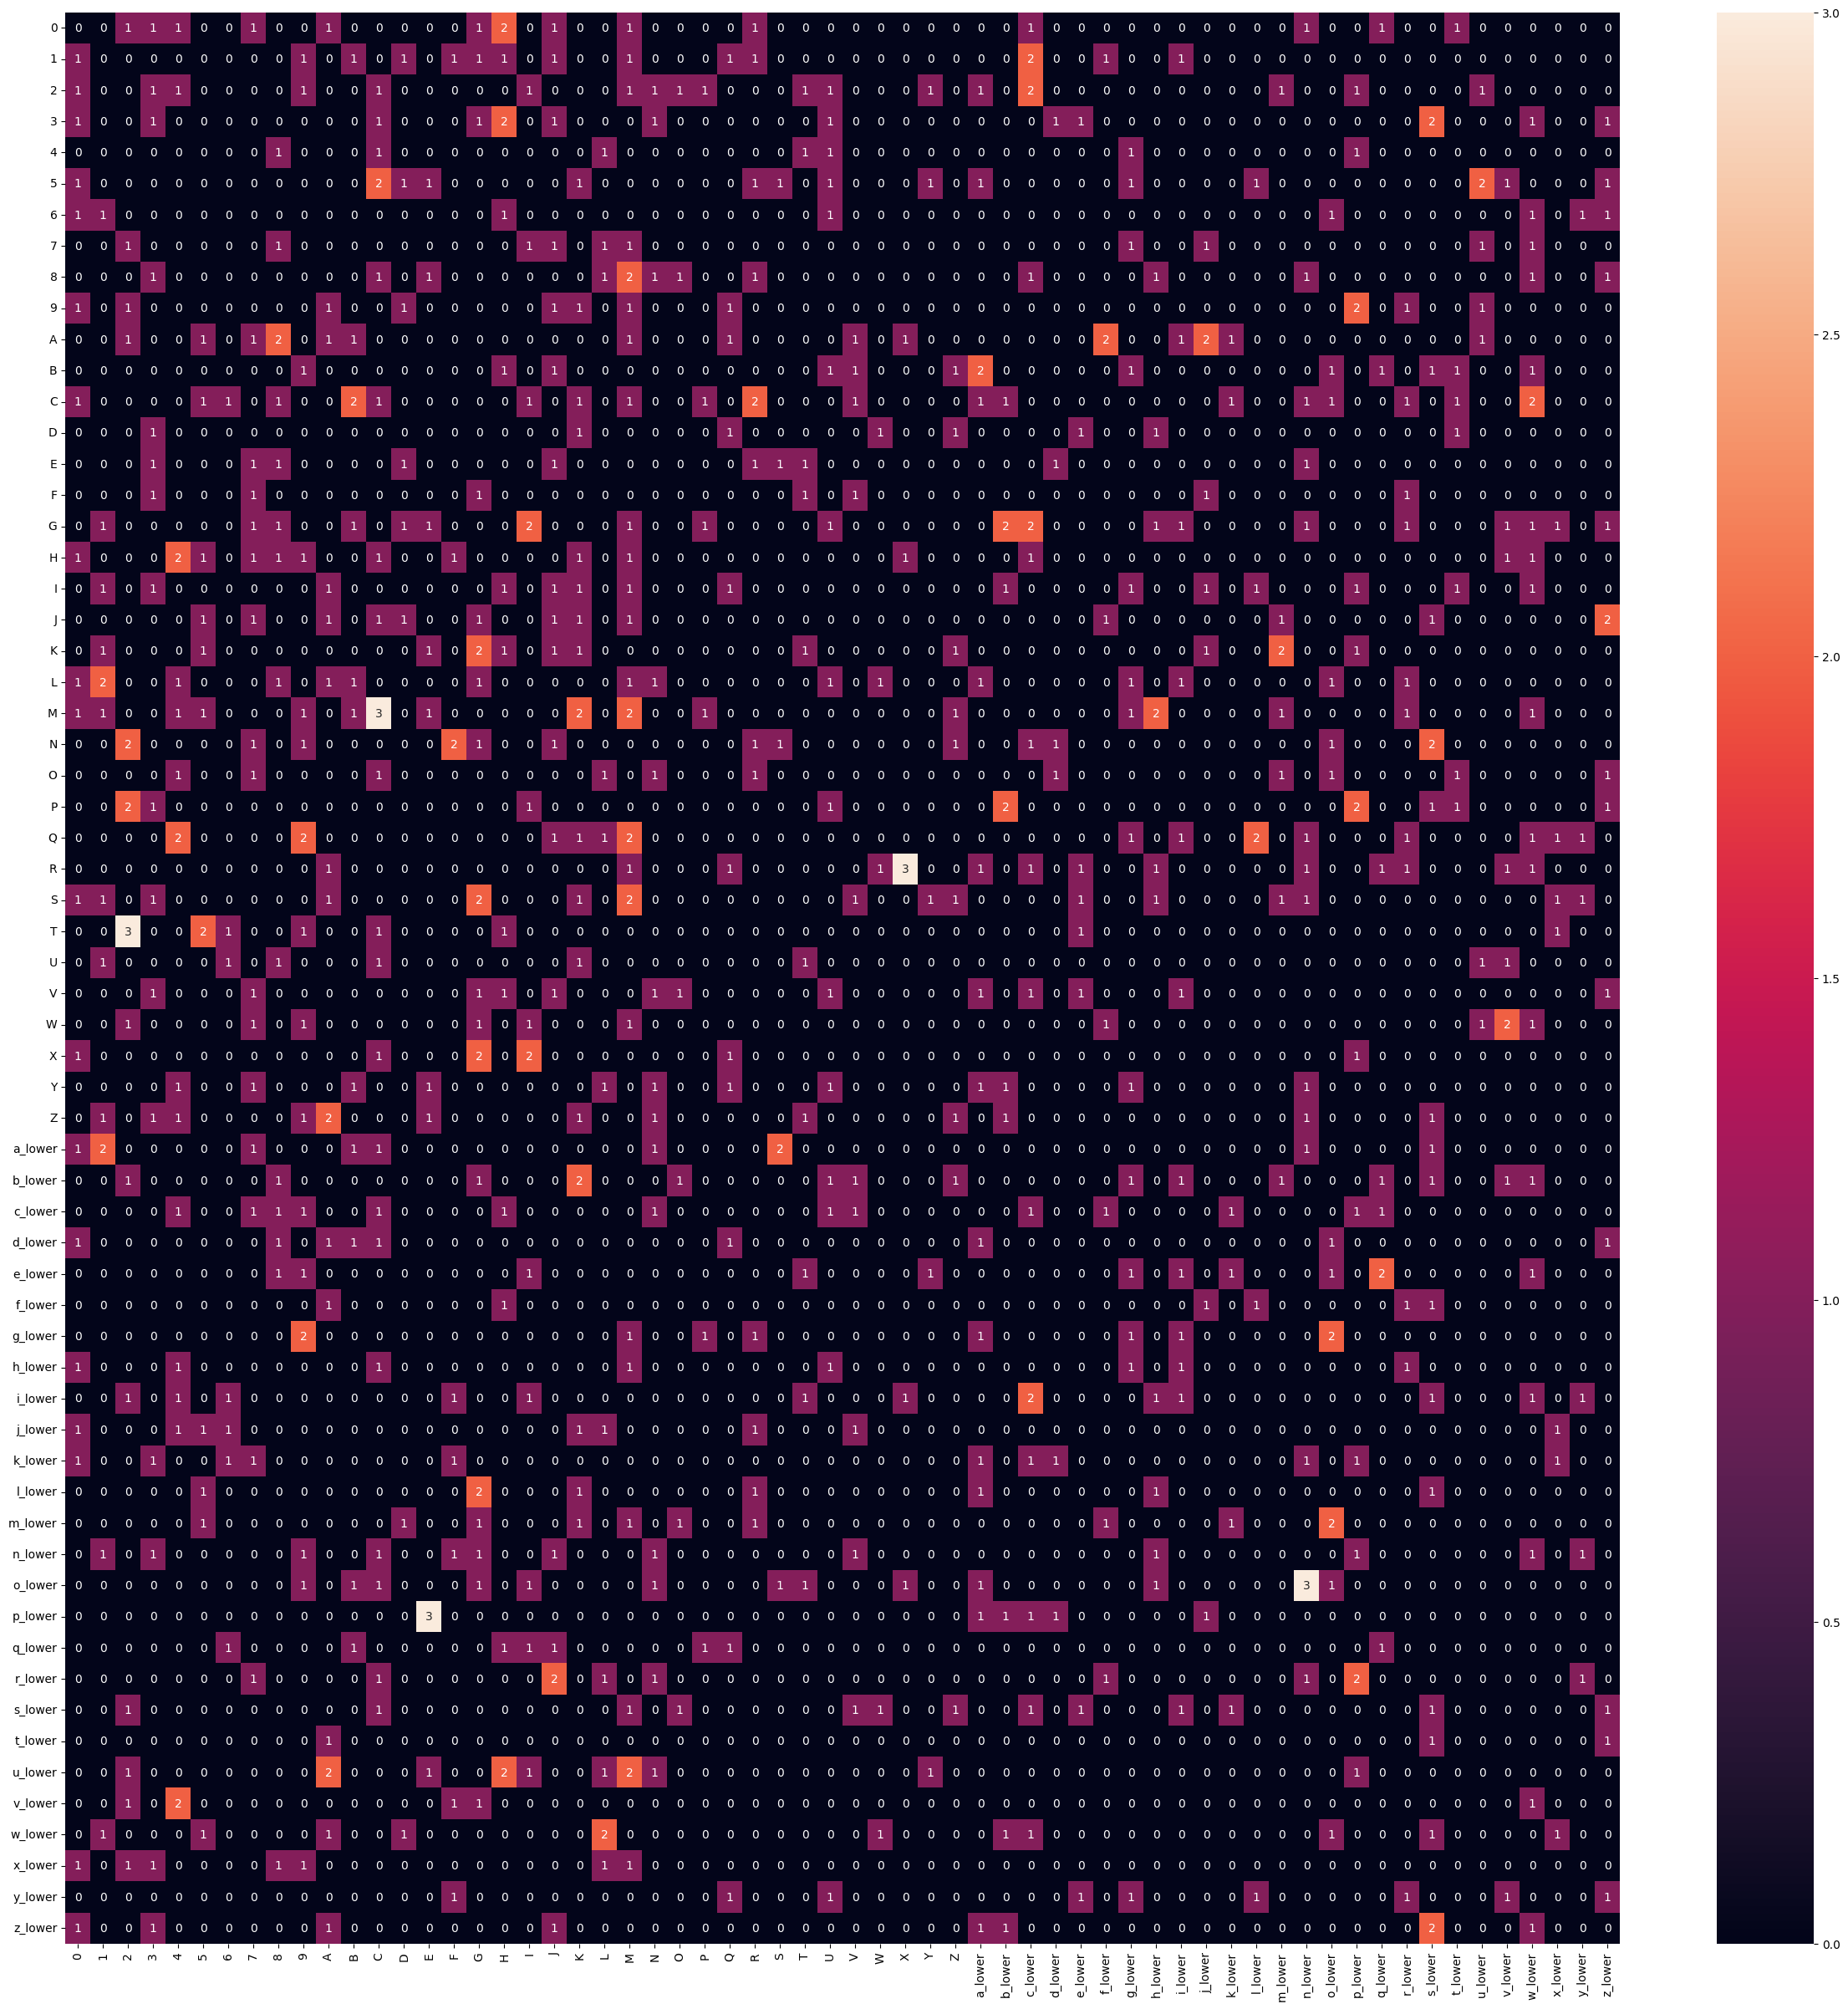

In [72]:
import seaborn as sn
import tensorflow_datasets as tfds
y = []
x = []

test_dataset_unbatched = test_dataset.unbatch()
#It is a list of tuples, where in each tuple you have a batch of input, then a batch of labels

for image, label in test_dataset_unbatched:
    x.append(image)
    y.append(np.argmax(label))


predictions = model.predict(test_dataset)
predictions = [np.argmax(entry) for entry in predictions]

matrix = tf.math.confusion_matrix(y, predictions, num_classes=62)

df_cm = pd.DataFrame(matrix, index = [i for i in string_labels],
                  columns = [i for i in string_labels])
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True)


Finally, let's save this model to be able to use it in our note-taking application.

In [73]:
model_cloned.save('../models/cnn_model')

INFO:tensorflow:Assets written to: ../models/cnn_model\assets


INFO:tensorflow:Assets written to: ../models/cnn_model\assets


### Visualizing Model's Learned Features

Pretty impressive! The model was able to achieve a really good accuracy!

To be able to get an insight as to how the model was able to achieve such an accuracy, we will be visualizing the outputs of the intermediate layers. That is, we will try to understand *what the features the model learned look like*.

(28, 28)

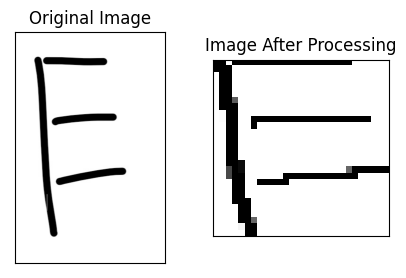

In [65]:
#Load a test image and preprocess it
original_test = matplotlib.image.imread("../src/test_images/test_10.jpg")
bounded, cropped_test = get_bounding_box("../src/test_images", "test_10.jpg")
test_image = cropped_test[0]

plt.figure(figsize=(5,3))

plt.subplot(1,2,1)
plt.imshow(original_test)
plt.xticks([])
plt.yticks([])
plt.title("Original Image")



plt.subplot(1,2,2)
plt.imshow(test_image, cmap="gray")
plt.xticks([])
plt.yticks([])
_ = plt.title("Image After Processing")

test_image.shape

In [66]:
test_image = np.array([test_image[:, :, np.newaxis]])
test_image.shape

(1, 28, 28, 1)

In [67]:
results = model.predict(test_image)
print(string_labels[np.argmax(results)])

1/1 [==============================] - 0s 80ms/step
E


Output of layer shape: (1, 28, 28, 32)


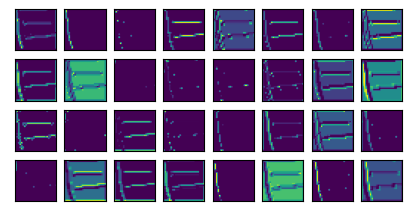

In [68]:
# Outputs of the 8 layers, which include conv2D and max pooling layers
layer_outputs = [layer.output for layer in model.layers[:6]]

activation_model = keras.models.Model(inputs = model.input, outputs = layer_outputs)

activations = activation_model.predict(test_image, verbose=0)
  
# Getting Activations of first layer
first_layer_activation = activations[0]
  
# shape of first layer activation
print(f"Output of layer shape: {first_layer_activation.shape}")
  

plt.figure(figsize=(5,2.5))
for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(first_layer_activation[0, :, :, i], cmap="viridis")
    plt.xticks([])
    plt.yticks([])
    
plt.show()

# Deployment <a id='deployment'></a>

Now that we have developed several models that can be used within the app, we can work on craeting a RESTful API for the app to be able to interact with the model.

To do so, we will be using the FLASK framework available in Python. 

The pipeline will be as follows:

1. User draws something on the Canvas in the app
2. 2s after the last stroke has been made, the app will automatically send a screenshot to the Flask Server
3. The Flask server will run a backend API that pre-processes the input, using the *get_bounding_box* function described earlier 
4. According to the language that was chosen by the user, the Flask server will do a forward pass through one of the pre-trained models discussed in this notebook. 
5. The server will return a string that represents the model's prediction of the drawing. This string will then be processed by the app to be displayed in-app.

The details of this implementation can be found in the code for the app itself. Th ecode for the Flask sever can be found in *api* folder